In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA # 추가(230703 재은)

In [2]:
# 데이터 불러오기
df = pd.read_csv('../data/apt_200101_200131.csv')

# EDA 1

In [3]:
# 보증금 전세
# 최근 전세 사기로 인한 피해자가 늘어남에 따라 실제 보증금의 금액을 유추하고 이상금액을 찾아 전세 사기를 막는 모델을 막는다

# 모델 1 : 보증금 금액 유추하는 모델 
# 모델 2 : 사기인지 아닌지 유추하는 모델(이상치 확인)

In [4]:
df.head()
# 문자, 숫자 섞여 있는 데이터

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,계약기간,계약구분,갱신요구권 사용,종전계약 보증금 (만원),종전계약 월세 (만원)
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,전세,79.97,202001,3,"43,000",0,1,1987,언주로 3,-,-,-,NaN,NaN
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,전세,79.97,202001,17,"45,000",0,5,1987,언주로 3,-,-,-,NaN,NaN
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,전세,79.97,202001,18,"44,000",0,4,1987,언주로 3,-,-,-,NaN,NaN
3,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,전세,133.46,202001,15,"90,000",0,11,1984,개포로 307,-,-,-,NaN,NaN
4,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,전세,133.46,202001,18,"85,000",0,11,1984,개포로 307,-,-,-,NaN,NaN


In [5]:
df.shape

# 16614 개의 레코드 데이터, 19개 컬럼

(16614, 19)

In [ ]:
# 컬럼 : 시군구, 번지, 본번, 부번, 단지명, 전월세구분, 전용면적(㎡), 계약년월, 계약일, 보증금(만원), 월세(만원), 층, 건축년도, 도로명, 계약기간, 계약구분,
#         갱신요구권 사용, 종전계약 보증금 (만원), 종전계약 월세 (만원)


# 컬럼 중 시군구, 번지, 본번, 부번, 도로명은 서로 성격이 겹치는 컬럼이기에 하나로 대표할 수 있는 시군구 컬럼만 남김
# 컬럼 중 계약년월, 계약일 중 계약일 컬럼만 남김
# 알아내고자 하는 것이 보증금이기 때문에 계약기간(유효한 값이 거의 없기에 그냥 삭제하기로함), 계약구분, 개신요구권사용, 종전계약보증금(만원), 종전계약 월세(만원)은 삭제하여 활용하기로 함 
# 이중에서도 전세에 관한 것을 알기 위해 전월세구분에서 전세로 필터링해 활용함


# 단어 의미 확인하기
# 시군구 : 행정 구역인 시와 군, 구를 아울러 이르는 말
# 단지명 : 주택, 공장, 작물 재배지 따위가 집단을 이루고 있는 일정 구역의 이름
# 전세 : 부동산의 소유주에게 일정한 돈을 맡기고 집이나 방을 빌려 쓰다가, 내놓을 때 그 돈의 전액을 돌려받는 제도 
# 전용면적 : 아파트 따위의 공동 주택에서, 출입구나 엘리베이터, 계단 등의 공유 면적을 제외한 바닥 넓이
# 계약년월 : 계약을 진행한 연도와 월
# 보증금 : 입찰 또는 계약을 맺을 때 계약 이행의 담보로 내는 금전
# 층 : 건물의 층 
# 건축년도 : 건물 완공 년

# 데이터 전처리1

In [6]:
# 현재 회귀모델의 가설은 다음과 같음
# 동, 아파트명, 아파트브랜드명, 전용면적, 계약년월, 층, 건축년도가 보증금에 영향을 준다


# 서울시 동별 보증금이 다를 것이라는 가설을 전제로 '동' 컬럼 추가
df['동'] = df['시군구'].str.replace('서울특별시', '')
df = df[df['전월세구분'] == '전세']
remove_gu = ['서울특별시 ', '강남구 ', '강동구 ', '강북구 ', '강서구 ', '관악구 ', '광진구 ','구로구 ', '금천구 ', '노원구 ', '도봉구 ', '동대문구 ', '동작구 ', '마포구 ', '서대문구 ', '서초구 ', '성동구 ', '성북구 ','송파구 ' , '양천구 ', '영등포구 ', '용산구 ', '은평구 ', '종로구 ', '중구 ', '중랑구 ']
df['동'] = df['시군구'].str.replace('|'.join(remove_gu), '', regex=True)

#데이터 보기 편하게 재배열
df = df[['시군구', '동', '단지명','전월세구분','전용면적(㎡)','계약년월','층', '건축년도', '보증금(만원)']]
df.head()

,시군구,동,단지명,전월세구분,전용면적(㎡),계약년월,층,건축년도,보증금(만원)
0,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,1,1987,"43,000"
1,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,5,1987,"45,000"
2,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,4,1987,"44,000"
3,서울특별시 강남구 개포동,개포동,개포우성3차,전세,133.46,202001,11,1984,"90,000"
4,서울특별시 강남구 개포동,개포동,개포우성3차,전세,133.46,202001,11,1984,"85,000"


In [7]:
# 보증금(만원) 컬럼이 문자로 저장되어 있어 숫자로 변환
df['보증금(만원)'] = df['보증금(만원)'].str.replace(",", "").astype(int)
df.head()

,시군구,동,단지명,전월세구분,전용면적(㎡),계약년월,층,건축년도,보증금(만원)
0,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,1,1987,43000
1,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,5,1987,45000
2,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,4,1987,44000
3,서울특별시 강남구 개포동,개포동,개포우성3차,전세,133.46,202001,11,1984,90000
4,서울특별시 강남구 개포동,개포동,개포우성3차,전세,133.46,202001,11,1984,85000


In [8]:
# 전용면적(㎡), 보증금(만원) 컬럼명에서 ()가 들어가 삭제함
df.rename(columns={'전용면적(㎡)': '전용면적'}, inplace=True)
df.rename(columns={'보증금(만원)': '보증금'}, inplace=True)
df.head()

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,보증금
0,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,1,1987,43000
1,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,5,1987,45000
2,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,4,1987,44000
3,서울특별시 강남구 개포동,개포동,개포우성3차,전세,133.46,202001,11,1984,90000
4,서울특별시 강남구 개포동,개포동,개포우성3차,전세,133.46,202001,11,1984,85000


# EDA 1
# 각 컬럼에 대한 특징 파악하기

In [9]:
# 1) 피처(Feature) 확인
df.columns

Index(['시군구', '동', '단지명', '전월세구분', '전용면적', '계약년월', '층', '건축년도', '보증금'], dtype='object')

In [10]:
# 2) 데이터 프레임 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11793 entries, 0 to 16613
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시군구     11793 non-null  object 
 1   동       11793 non-null  object 
 2   단지명     11793 non-null  object 
 3   전월세구분   11793 non-null  object 
 4   전용면적    11793 non-null  float64
 5   계약년월    11793 non-null  int64  
 6   층       11793 non-null  int64  
 7   건축년도    11793 non-null  int64  
 8   보증금     11793 non-null  int32  
dtypes: float64(1), int32(1), int64(3), object(4)
memory usage: 875.3+ KB


In [11]:
# 3) 데이터 프레임 통계값 (전체)
df.describe()

,전용면적,계약년월,층,건축년도,보증금
count,11793.000000,11793.0,11793.000000,11793.000000,11793.000000
mean,74.690385,202001.0,9.066989,2001.142881,45226.743661
std,27.586954,0.0,6.057245,11.492580,26264.652552
min,10.321500,202001.0,1.000000,1968.000000,1600.000000
25%,59.640000,202001.0,4.000000,1993.000000,29000.000000
50%,76.790000,202001.0,8.000000,2001.000000,40000.000000
75%,84.951000,202001.0,13.000000,2010.000000,55000.000000
max,244.770000,202001.0,61.000000,2022.000000,300000.000000


In [12]:
# 동 : 서울의 동을 나누었을 때 274개로 나누었으며(충무로1가, 장충동2가 등 포함) 가장 많은 거래(426건)가 상계동에서 있었다는 것을 알 수 있음
df.동.describe()

count     11793
unique      274
top         상계동
freq        426
Name: 동, dtype: object

In [13]:
# 단지명 : 2580의 서로 다른 아파트들이 있다는 것을 알 수 있음 -> 아파트명이 많이 겹침
df.단지명.describe()

count      11793
unique      2580
top       고덕아르테온
freq         126
Name: 단지명, dtype: object

In [14]:
# 전용면적 : 거래된 아파트 중 가장 작은 전용면적은 10.321500(㎡), 가장 넓은 전용면적은 244.770000(㎡) 임
df.전용면적.describe()

count    11793.000000
mean        74.690385
std         27.586954
min         10.321500
25%         59.640000
50%         76.790000
75%         84.951000
max        244.770000
Name: 전용면적, dtype: float64

In [1]:
plt.hist(df.전용면적.value_counts())
plt.xlabel('AREA')
plt.ylabel('COUNT')
plt.show()
# 전용면적을 보면 대부분의 거래가 50(㎡) 이하, 더 정확하게는 25(㎡)이하로 이루어지고 있음을 알 수 있음

NameError: name 'plt' is not defined

In [16]:
# 계약년월 : 현재는 2020.01 자료만 활용했기 때문에 맞게 나오고 있음
df.계약년월.describe()

count     11793.0
mean     202001.0
std           0.0
min      202001.0
25%      202001.0
50%      202001.0
75%      202001.0
max      202001.0
Name: 계약년월, dtype: float64

In [17]:
# 층 : 1~61층까지 분포 (지하층이 있는지 확인)
df.층.describe()

count    11793.000000
mean         9.066989
std          6.057245
min          1.000000
25%          4.000000
50%          8.000000
75%         13.000000
max         61.000000
Name: 층, dtype: float64

In [18]:
#건축년도 : 1968년도~2022년도 신축까지 다양함
df.건축년도.describe()

count    11793.000000
mean      2001.142881
std         11.492580
min       1968.000000
25%       1993.000000
50%       2001.000000
75%       2010.000000
max       2022.000000
Name: 건축년도, dtype: float64

In [19]:
# 보증금 : 제일 저렴한 것은 1600만원, 비싼 것은 300000만원이 나온다는 것을 알 수 있음
df.보증금.describe()

count     11793.000000
mean      45226.743661
std       26264.652552
min        1600.000000
25%       29000.000000
50%       40000.000000
75%       55000.000000
max      300000.000000
Name: 보증금, dtype: float64

In [20]:
#저렴한 곳
df.loc[df['보증금']==1600]

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,보증금
2761,서울특별시 강북구 번동,번동,주공1단지,전세,49.94,202001,11,1991,1600


In [21]:
#비싼곳
df.loc[df['보증금']==300000]

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,보증금
606,서울특별시 강남구 도곡동,도곡동,타워팰리스2,전세,244.04,202001,49,2003,300000


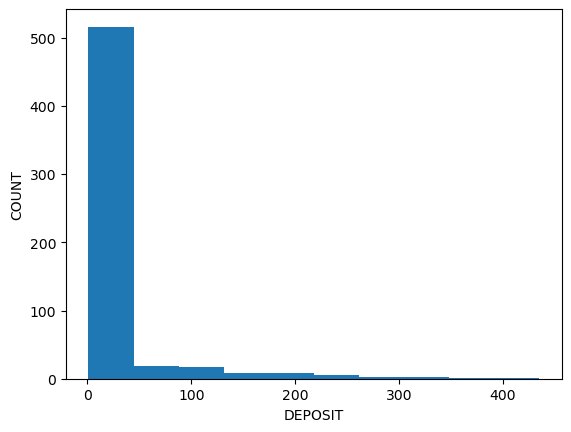

In [22]:
plt.hist(df.보증금.value_counts())
plt.xlabel('DEPOSIT')
plt.ylabel('COUNT')
plt.show()
# 50(만원) 이하 많음

## 데이터 전처리2 : 문자 데이터 수치화하기

In [23]:
# 단지명 기준 매매 많은 상위 40권 아파트 : 이름이 겹치는 곳이 많음 
df['단지명'].value_counts()[:40]

고덕아르테온         126
현대              95
고덕센트럴IPARK      92
고덕롯데캐슬베네루체      86
두산              84
신동아             83
은마              79
삼성              60
우성              58
삼성래미안           58
주공2             49
신길센트럴자이아파트      47
한양수자인사가정파크      45
벽산              45
한신              43
노원센트럴푸르지오       43
주공아파트 5단지       42
대림e-편한세상        42
쌍용              41
목동신시가지7         38
동아              38
중앙하이츠           37
선사현대아파트         36
고덕그라시움          36
북한산두산위브         36
잠실엘스            36
보라매에스케이뷰        35
극동              34
미성              33
대림              33
강남데시앙파크         32
목동신시가지14        32
삼익그린2차          31
파크리오            31
이편한세상금호파크힐스     31
에스케이북한산시티       31
삼환              30
영등포푸르지오         30
상계주공7(고층)       29
주공5             29
Name: 단지명, dtype: int64

In [24]:
# 같은 아파트 이름을 갖는 수를 저장하는 apt_count 열 생성
df['apt_counts'] = 0
df.groupby('단지명')['apt_counts'].count()
df = pd.merge(df, df.groupby('단지명')['apt_counts'].count(), on='단지명', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})
df.head(3)

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,보증금,apt_counts
0,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,1,1987,43000,3
1,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,5,1987,45000,3
2,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,4,1987,44000,3


* 시공사명이 아파트값에 영향을 줄 수 있다는 가설추가+  (재은)

In [25]:
# 비슷한 아파트들(숫자같은 것으로)끼리 여러번 나오는 것 방지, top시공사 10곳, 데이터에서 많이 나오는 아파트 25개의 이름 통일하기
# top시공사 10곳은 2022년도 종합건설사업자 시공능력평가액 <토목건축공사업> 참고& 시공사들끼리 동일 아파트를 짓는 경우가 있어 시공사 및 아파트명으로 검색 진행
'''
삼성물산 주식회사 - 래미안
현대건설(주) - 힐스테이트
디엘이앤씨(주) - 이편한|e편한|e-편한
(주)포스코건설 - 더샵
지에스건설(주) - 자이
(주)대우건설 - 푸르지오
현대엔지니어링(주) - 아이파크|IPARK
롯데건설(주) - 롯데캐슬
에스케이에코플랜트(주) - sk|SK|에스케이
에이치디씨현대산업개발(주)
(주)태영건설 - 데시앙
'''
df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한', '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

df['단지명'] = df['단지명'].fillna('others')

# top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
    df.loc[df['단지명'].str.contains(brand), 'top10'] = 1

df.head(5)

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,보증금,apt_counts,top10
0,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,1,1987,43000,3,0
1,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,5,1987,45000,3,0
2,서울특별시 강남구 개포동,개포동,개포6차우성아파트1동~8동,전세,79.97,202001,4,1987,44000,3,0
3,서울특별시 강남구 개포동,개포동,개포우성3차,전세,133.46,202001,11,1984,90000,2,0
4,서울특별시 강남구 개포동,개포동,개포우성3차,전세,133.46,202001,11,1984,85000,2,0


In [26]:
# 데이터에 많이 있는 아파트 대표 25개 리스트
apt_names = ['고덕아르테온','현대','삼익그린2차','두산','신동아','은마','삼성','우성', '주공2', '한양수자인사가정파크','벽산','한신','주공아파트 5단지',
                   '쌍용','목동신시가지7','동아','중앙하이츠','선사현대','고덕그라시움','북한산두산위브','잠실엘스','극동','미성','대림','목동신시가지14','삼환']
# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names

In [27]:
# `apt_names_list`의 키워드에 해당하는 아파트명이 있는지 여부를 나타내는 새로운 컬럼 생성
df['transformed'] = False

In [28]:
# `apt_names_list`의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명 통일
#  transformed` 컬럼값 True로 변경
for a in (apt_names_list):
    df.loc[df['단지명'].str.contains(a), '단지명'] = a
    df.loc[df['단지명'].str.contains(a), 'transformed'] = True

In [29]:
# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경
for a in (apt_names):
    df.loc[~df['transformed'], '단지명'] = 'others'

In [30]:
df['단지명'].value_counts()

others          5942
현대               780
래미안              602
푸르지오             363
우성               335
동아               326
힐스테이트            299
자이               274
이편한|e편한|e-편한     257
롯데캐슬             243
삼성               241
한신               229
두산               228
아이파크             197
대림               159
sk|SK|에스케이       127
고덕아르테온           126
쌍용               125
벽산               121
극동               102
은마                79
주공2               75
중앙하이츠             71
미성                69
더샵                63
데시앙               61
한양수자인사가정파크        45
주공아파트 5단지         42
삼환                39
목동신시가지7           38
고덕그라시움            36
잠실엘스              36
목동신시가지14          32
삼익그린2차            31
Name: 단지명, dtype: int64

In [31]:
# 아파트별 가격 평균 내림차순으로 정렬
apt_price = df.groupby('단지명')['보증금'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

변환전
 단지명
잠실엘스    88083.333333
더샵      70598.333333
자이      65840.492701
래미안     64266.313953
롯데캐슬    60653.004115
Name: 보증금, dtype: float64


In [32]:
#가격별로 0~ 인코딩 해주기
for i, a in enumerate(list(apt_price.index)):
    df.loc[df['단지명'] == a, '단지명'] = i 
apt_price = df.groupby('단지명')['보증금'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

변환후
 단지명
0    88083.333333
1    70598.333333
2    65840.492701
3    64266.313953
4    60653.004115
Name: 보증금, dtype: float64


In [33]:
# 완공연도에서 최소연도 빼서 완공연도 라벨인코딩
print('변환전\n', df['건축년도'].unique()[:5])
df['건축년도'] = df['건축년도'] - df['건축년도'].min()
print('변환후\n', df['건축년도'].unique()[:5])

변환전
 [1987 1984 2004 1983 1993]
변환후
 [19 16 36 15 25]


In [34]:
# 연월 증가하는 순으로 라벨 인코딩 : 계약년월
le = LabelEncoder()
df['계약년월'] = le.fit_transform(df['계약년월'])
print('train 변환후\n', df['계약년월'])
print('test 변환후\n', df['계약년월'].unique()[:5])

train 변환후
 0        0
1        0
2        0
3        0
4        0
        ..
11788    0
11789    0
11790    0
11791    0
11792    0
Name: 계약년월, Length: 11793, dtype: int64
test 변환후
 [0]


In [35]:
df.head(5)

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,보증금,apt_counts,top10,transformed
0,서울특별시 강남구 개포동,개포동,16,전세,79.97,0,1,19,43000,3,0,True
1,서울특별시 강남구 개포동,개포동,16,전세,79.97,0,5,19,45000,3,0,True
2,서울특별시 강남구 개포동,개포동,16,전세,79.97,0,4,19,44000,3,0,True
3,서울특별시 강남구 개포동,개포동,16,전세,133.46,0,11,16,90000,2,0,True
4,서울특별시 강남구 개포동,개포동,16,전세,133.46,0,11,16,85000,2,0,True


In [36]:
# 동 인코딩하기

#동 EDA
dong_price = df.groupby('동')['보증금'].agg('mean').sort_values(ascending=False)
dong_price[:20]

#현재 데이터에서는 가장 비싼 동은 종로구 내수동

동
내수동       120000.000000
하중동       115000.000000
용산동5가     112400.000000
도곡동        96121.020408
남대문로5가     95000.000000
반포동        94562.192982
청담동        90826.278689
홍파동        90222.222222
대치동        86011.764706
평동         85980.000000
한강로1가      84000.000000
서교동        83500.000000
압구정동       82608.974359
신계동        81200.000000
한강로2가      80850.000000
한남동        80805.555556
삼성동        80156.250000
방배동        77991.743119
잠실동        76938.379888
회현동1가      73200.000000
Name: 보증금, dtype: float64

In [37]:
# 동별 인코딩
for i, d in enumerate(list(dong_price.index)):
    df.loc[df['동'] == d, '동'] = i

df

,시군구,동,단지명,전월세구분,전용면적,계약년월,층,건축년도,보증금,apt_counts,top10,transformed
0,서울특별시 강남구 개포동,64,16,전세,79.97,0,1,19,43000,3,0,True
1,서울특별시 강남구 개포동,64,16,전세,79.97,0,5,19,45000,3,0,True
2,서울특별시 강남구 개포동,64,16,전세,79.97,0,4,19,44000,3,0,True
3,서울특별시 강남구 개포동,64,16,전세,133.46,0,11,16,90000,2,0,True
4,서울특별시 강남구 개포동,64,16,전세,133.46,0,11,16,85000,2,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
11788,서울특별시 중랑구 중화동,231,23,전세,50.37,0,24,29,28000,11,0,True
11789,서울특별시 중랑구 중화동,231,23,전세,59.76,0,7,29,31000,11,0,True
11790,서울특별시 중랑구 중화동,231,23,전세,50.37,0,6,29,27000,11,0,True
11791,서울특별시 중랑구 중화동,231,23,전세,50.37,0,5,29,26000,11,0,True


In [38]:
# 층 수 확인
print(df['층'].values[:5])

[ 1  5  4 11 11]


In [39]:
# 시군구,전세 컬럼 삭제
df = df.drop(['시군구', '전월세구분'], axis=1)
df.head()

,동,단지명,전용면적,계약년월,층,건축년도,보증금,apt_counts,top10,transformed
0,64,16,79.97,0,1,19,43000,3,0,True
1,64,16,79.97,0,5,19,45000,3,0,True
2,64,16,79.97,0,4,19,44000,3,0,True
3,64,16,133.46,0,11,16,90000,2,0,True
4,64,16,133.46,0,11,16,85000,2,0,True


# 변수 간 연관분석  # 추가(230703 재은)

In [40]:
# 변수로 뽑은 동, 단지명, 전용면적, 계약년월, 층, 건축년도, 보증금 등을 모두 숫자화 함
# 상관분석을 위해 df에서 시군구를 제외하고 동~ 다시 reframe진행함, 표를 보기 위해 영어로 변수 변경
# 상관분석 데이터는 기존 데이터 복사본으로 진행 & 동, 단지명, 전용면적, 계약년월, 층, 건축년도, 추가한 top10, 보증금만 확인

In [41]:
# PCA를 수행 데이터
df_copy = df.copy()
df_copy = df_copy[['동', '단지명', '전용면적', '계약년월', '층', '건축년도','top10', '보증금']]
df_copy.columns = ['dong', 'apt_name', 'area', 'contract_month', 'floor', 'construction_year','top10', 'deposit']

# PCA를 수행합니다.
pca = PCA()
pca.fit(df_copy)

# PCA 결과를 해석
print(pca.explained_variance_ratio_)

[9.99993696e-01 5.39394784e-06 6.38594189e-07 1.69993546e-07
 5.25929646e-08 4.87857113e-08 8.73669287e-11 3.61518155e-41]


In [42]:
# 첫 번째 주성분이 데이터의 99.99%의 분산을 설명하기 때문에 따로 차원축소를 할 필요가 없음

# 상관분석

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_18340\2155561838.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr=df_copy.corr()


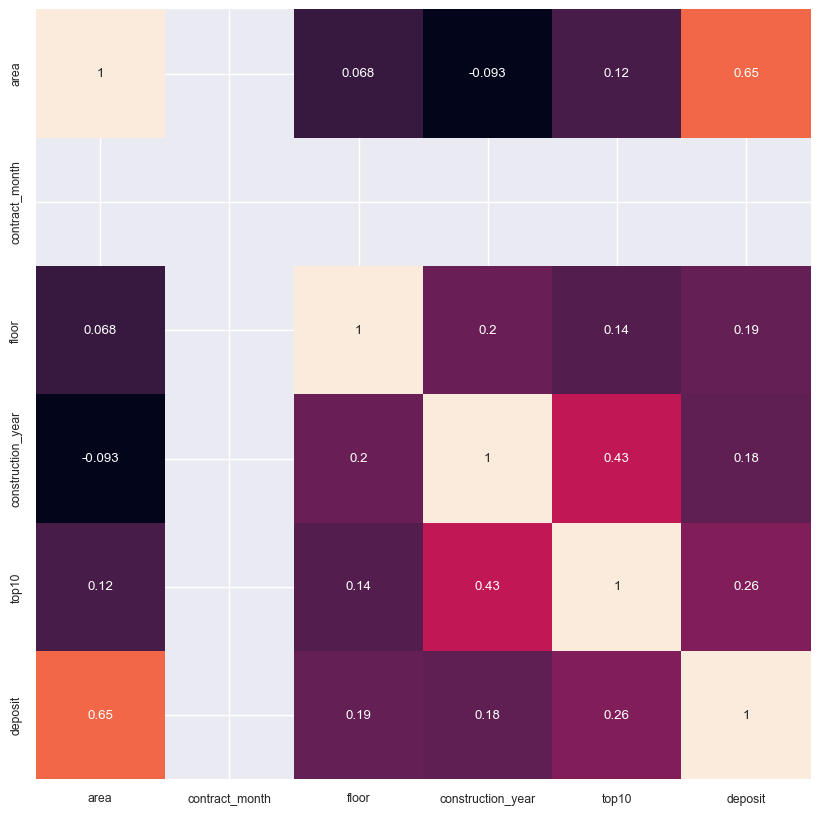

In [43]:
# 상관분석1: 상관 관계 행렬
# 'dong', 'apt_name' 가 범주형 값이기 때문에 더미코드 활용 : 이걸로 돌리면 무지하게 오래 걸립니다.
# df_dummies = pd.get_dummies(df_copy, columns=['dong', 'apt_name'])
# df_corr = df_dummies.corr()

#퍼포먼스 저하로 일단 두가지 항목 제외한 히트맵 확인
df_corr=df_copy.corr()

#히트맵
plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(df_corr, annot=True, cbar=False)
plt.show()

In [44]:
# 보증금과 가장 상관관계가 높은 순으로 출력하기
corr_order = df_copy.corr().loc[:'top10', 'deposit'].abs().sort_values(ascending=False)
corr_order

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_18340\1288456240.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_order = df_copy.corr().loc[:'top10', 'deposit'].abs().sort_values(ascending=False)


area                 0.654156
top10                0.261728
floor                0.193018
construction_year    0.179688
contract_month            NaN
Name: deposit, dtype: float64

In [45]:
# 더미 적용 & 더미미적용 두 가지 일단 같은 값으로 나옴

In [46]:
# 상관분석2 :  선형회귀로 확인하기
# 시각화로 상관분석할 피처 정하기
plot_cols = ['deposit', 'area','top10','floor','construction_year','contract_month']
plot_df = df_copy.loc[:, plot_cols]

plot_df.head()

,deposit,area,top10,floor,construction_year,contract_month
0,43000,79.97,0,1,19,0
1,45000,79.97,0,5,19,0
2,44000,79.97,0,4,19,0
3,90000,133.46,0,11,16,0
4,85000,133.46,0,11,16,0


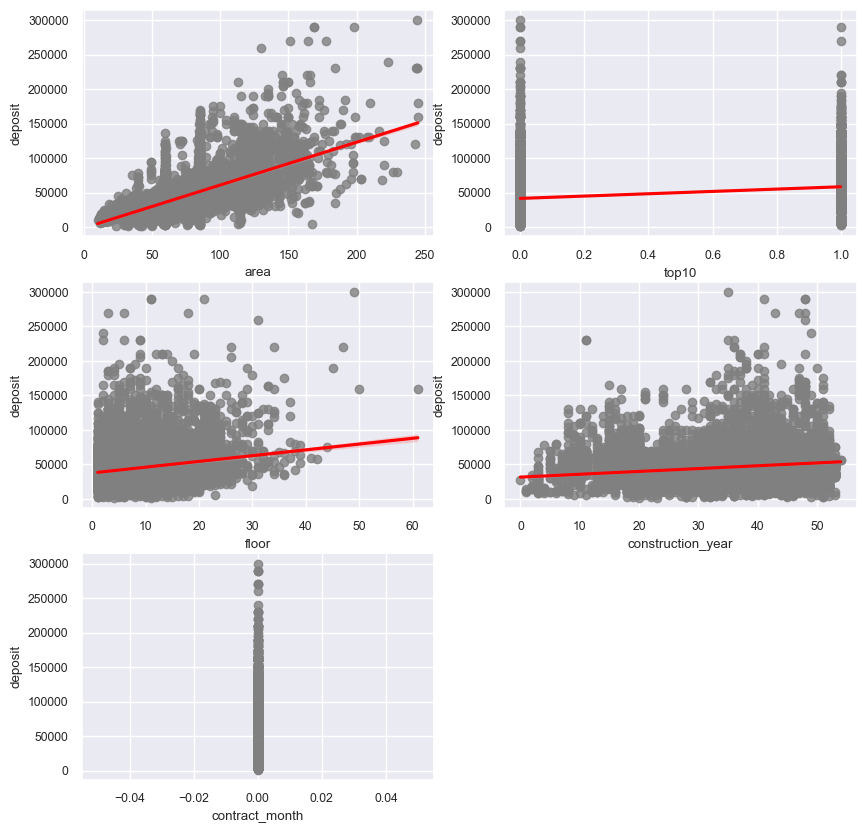

In [47]:
# regplot으로 선형회귀선 표시하기
plt.figure(figsize=(10, 10))
for idx, col in enumerate(plot_cols[1:]):
  ax1 = plt.subplot(3, 2, idx + 1)
  sns.regplot(x=col, y=plot_cols[0], data=plot_df, ax=ax1, color='gray', line_kws={'color': 'red'}) #회귀선 잘 보이게 수정(230703 재은)
plt.show()

In [48]:
# 보증금과 비교했을 시
# 면적은 양의 상관관계가 있음
# 층 역시 양의 상관관계가 보입
# top10은 시각화했 시 연관성잘 보이지 않지만, 상관관계가 높은 순으로 출력하면 면적 다음으로 영향을 주는 것으로 나옴
# contract_month, construction_year와 관련해서는 자료부족으로 조금 더 많은 분석이 필요함 

In [49]:
# 상관분석3 : 스피어만 상관계수로 확인해보기 # 추가(230703 재은)

In [50]:
df_copy = df.copy()
df_copy = df_copy[['동', '단지명', '전용면적', '계약년월', '층', '건축년도','top10', '보증금']]
df_copy.columns = ['dong', 'apt_name', 'area', 'contract_month', 'floor', 'construction_year','top10', 'deposit']
df_copy.head()

,dong,apt_name,area,contract_month,floor,construction_year,top10,deposit
0,64,16,79.97,0,1,19,0,43000
1,64,16,79.97,0,5,19,0,45000
2,64,16,79.97,0,4,19,0,44000
3,64,16,133.46,0,11,16,0,90000
4,64,16,133.46,0,11,16,0,85000


In [51]:
# 범주형 변수 순위 변수로 변환
# 범주형의 숫자 값은 연속형의 의미를 가지는 숫자가 아니기 때문에 해석에 있어 주의할 것!
df_copy['top10'] = df_copy['top10'].astype('category').cat.codes
df_copy['dong'] = df_copy['dong'].astype('category').cat.codes

# 스피어만 상관계수 계산
r = df_copy.corr(method='spearman')

# 스피어만 상관계수를 출력
print(r)

# 스피어만 상관계수 읽는 방법
# 1에 가까울수록 두 변수 간의 상관관계가 강하고, -1에 가까울수록 두 변수 간의 상관관계가 약함 (설사약과 변비약)
# 스피어만 상관계수 값이 0에 가까울수록 두 변수 간의 상관관계가 없음

                       dong      area  contract_month     floor  \
dong               1.000000 -0.306399             NaN -0.048456   
area              -0.306399  1.000000             NaN  0.056323   
contract_month          NaN       NaN             NaN       NaN   
floor             -0.048456  0.056323             NaN  1.000000   
construction_year -0.060223  0.043615             NaN  0.173686   
top10             -0.124763  0.167108             NaN  0.122919   
deposit           -0.676504  0.681067             NaN  0.145187   

                   construction_year     top10   deposit  
dong                       -0.060223 -0.124763 -0.676504  
area                        0.043615  0.167108  0.681067  
contract_month                   NaN       NaN       NaN  
floor                       0.173686  0.122919  0.145187  
construction_year           1.000000  0.443378  0.235904  
top10                       0.443378  1.000000  0.311658  
deposit                     0.235904  0.311658  1.

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_18340\2789308248.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  r = df_copy.corr(method='spearman')


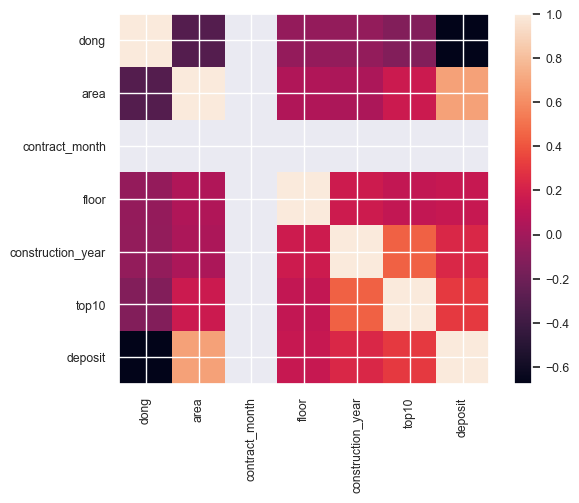

In [52]:
# 히트맵으로 확인
plt.imshow(r)
plt.xticks(np.arange(len(r.columns)), r.columns, rotation='vertical')
plt.yticks(np.arange(len(r.columns)), r.columns)
plt.colorbar()
plt.show()

C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


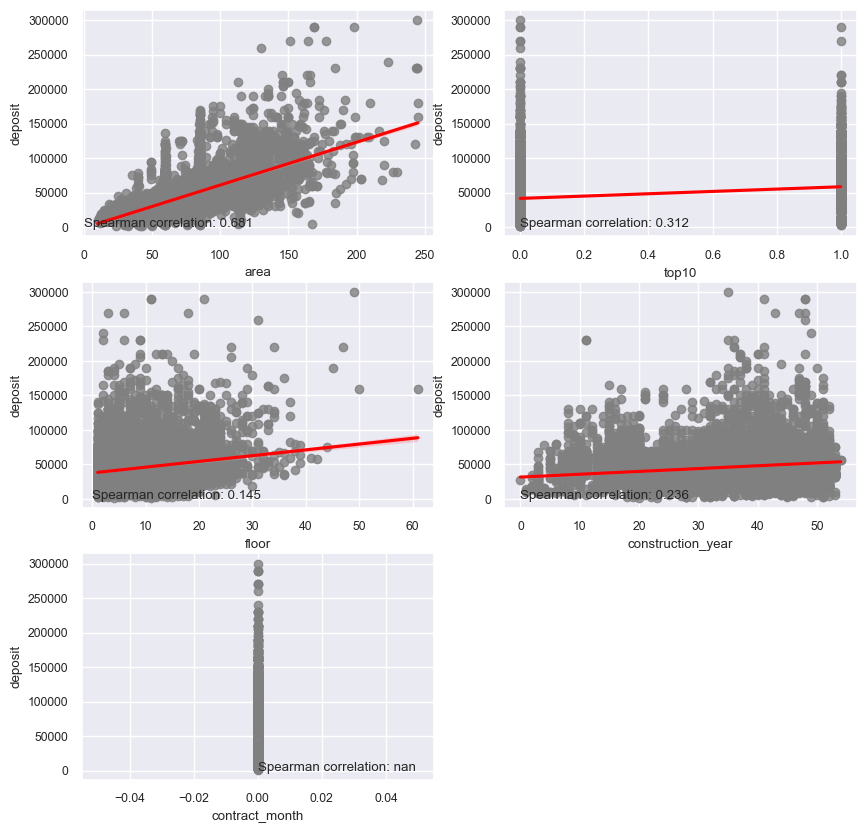

In [53]:
# 산점도로 확인하기
plt.figure(figsize=(10, 10))
for idx, col in enumerate(plot_cols[1:]):
  ax1 = plt.subplot(3, 2, idx + 1)
  sns.regplot(x=col, y=plot_cols[0], data=plot_df, ax=ax1, color='gray', line_kws={'color': 'red'})
  ax1.text(x=0, y=1, s='Spearman correlation: {0:.3f}'.format(plot_df[col].corr(plot_df['deposit'], method='spearman')))
plt.show()

# 전처리 3
실제 값들이 정규분포를 이루고 있는지 확인(회귀모델의 전제는 값들이 정규분포를 이루고 있다는 것에서 시작함)

C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

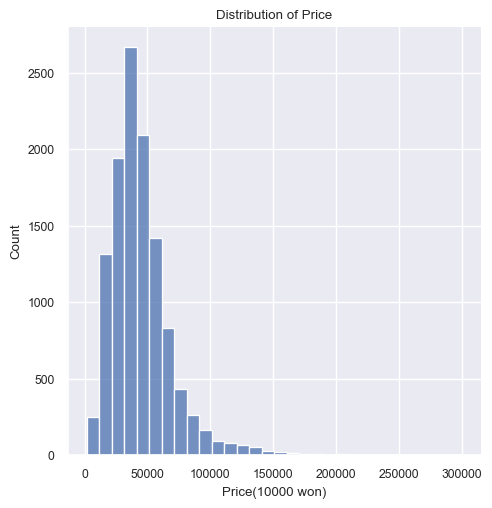

In [54]:
# 보증금 EDA
plt.figure()
sns.displot(df['보증금'], bins=30)
plt.xlabel('Price(10000 won)')
plt.title('Distribution of Price')
plt.show()

In [55]:
# 예상대로 왼쪽으로 엄청나게 많이 치우쳐 있음(왜도 왼쪽으로 치우침)
# 타겟 변수의 이상치가 회귀모형을 사용한 예측에 큰 영향을 줄 수 있어 로그 변환후 추후 다시 역변환 하는 것으로

* 왜도 왼쪽으로 치우칠때 로그가 아니라 제곱으로 진행해야 하는건지...? --확인! 

In [56]:
df['log_price'] = np.log1p(df['보증금'])
real_price = df['보증금'] # 원래 가격
df.drop('보증금', axis=1, inplace=True)
df.head(1)

,동,단지명,전용면적,계약년월,층,건축년도,apt_counts,top10,transformed,log_price
0,64,16,79.97,0,1,19,3,0,True,10.668979


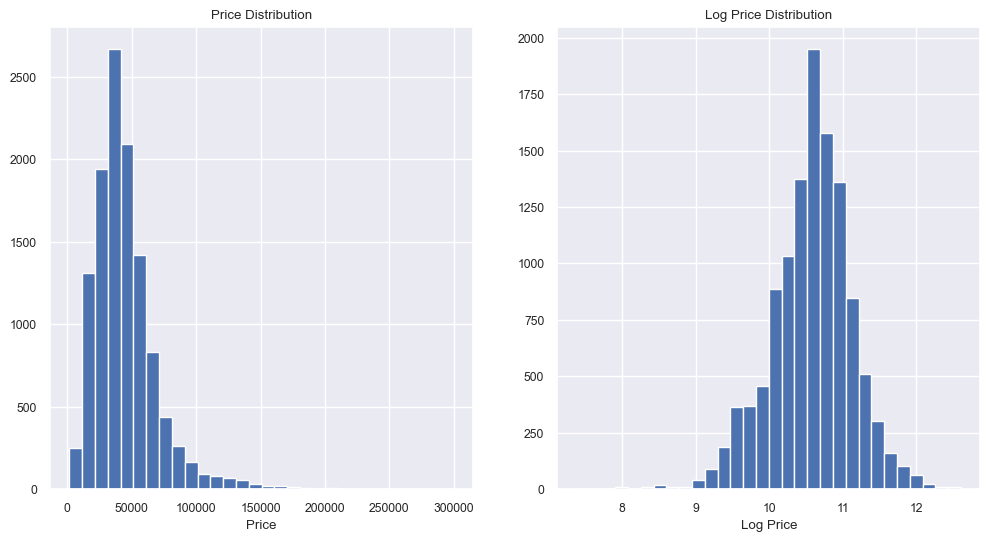

In [57]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_price, bins=30)
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price')

ax2.hist(df['log_price'], bins=30)
ax2.set_title('Log Price Distribution')
ax2.set_xlabel('Log Price')

plt.show()

In [58]:
# 나름 정규분포화 시킴(휴~)

C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

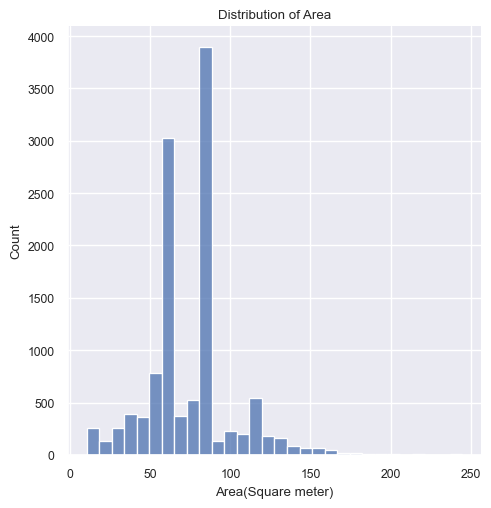

In [59]:
# 전용면적 EDA
plt.figure()
sns.displot(df['전용면적'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

In [60]:
# 정규분포화 되어 있는건지 아닌지 애매해서 로그함수 이용해서 한 번 더 전처리 진행
# 면적 로그 변환 후 원래 면적 따로 저장
df['log_area'] = np.log1p(df['전용면적'])
df['log_area'] = np.log1p(df['전용면적'])
area = df['전용면적'] # 원래 전용면적
df.drop('전용면적', axis=1, inplace=True)
df.head(1)

,동,단지명,계약년월,층,건축년도,apt_counts,top10,transformed,log_price,log_area
0,64,16,0,1,19,3,0,True,10.668979,4.394079


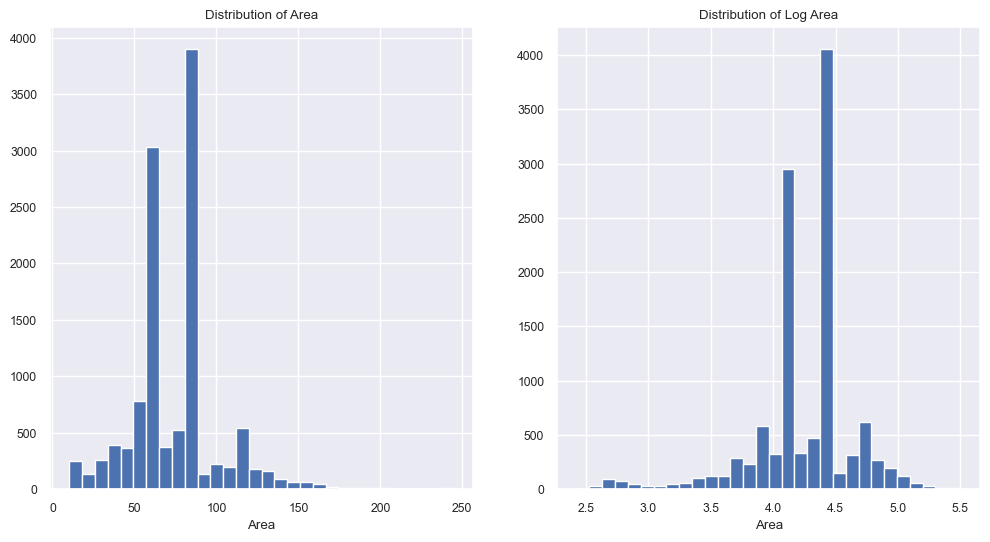

In [61]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(area, bins=30)
ax1.set_title('Distribution of Area')
ax1.set_xlabel('Area')

ax2.hist(df['log_area'], bins=30)
ax2.set_title('Distribution of Log Area')
ax2.set_xlabel('Area')

plt.show()

In [62]:
# 조금 더 정규화되어 로그변환값으로 활용하는 것으로

In [63]:
# 불필요한 컬럼 삭제2
drop_col = ['apt_counts', 'transformed']
df.drop(drop_col, axis=1, inplace=True)

In [64]:
# 모든 자료 수치화된 것인지 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11793 entries, 0 to 11792
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   동          11793 non-null  object 
 1   단지명        11793 non-null  object 
 2   계약년월       11793 non-null  int64  
 3   층          11793 non-null  int64  
 4   건축년도       11793 non-null  int64  
 5   top10      11793 non-null  int64  
 6   log_price  11793 non-null  float64
 7   log_area   11793 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 829.2+ KB


In [65]:
# 동과 단지명이 숫자화 되어 있지 않아 int형으로 변환 진행
df['동'] = df['동'].astype('int64')
df['단지명'] = df['단지명'].astype('int64')

In [66]:
# 다시 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11793 entries, 0 to 11792
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   동          11793 non-null  int64  
 1   단지명        11793 non-null  int64  
 2   계약년월       11793 non-null  int64  
 3   층          11793 non-null  int64  
 4   건축년도       11793 non-null  int64  
 5   top10      11793 non-null  int64  
 6   log_price  11793 non-null  float64
 7   log_area   11793 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 829.2 KB


In [67]:
df.head()

,동,단지명,계약년월,층,건축년도,top10,log_price,log_area
0,64,16,0,1,19,0,10.668979,4.394079
1,64,16,0,5,19,0,10.714440,4.394079
2,64,16,0,4,19,0,10.691968,4.394079
3,64,16,0,11,16,0,11.407576,4.901267
4,64,16,0,11,16,0,11.350418,4.901267


# 전처리 4 
스케일링 진행(정규화/표준화 진행)
서로 영향 안주려면 더미코드 필요한가????   
의논 : 더미화하면 퍼포먼스 시간 10~20배 더 걸림;ㅁ; 그냥 진행하는 것으로

In [68]:
scaler=MinMaxScaler()

#마지막열임을 나타내는 -1은 포함하지 않음
df_scaled=df.iloc[:, :-1]   
scaler.fit(df_scaled)
df_scaled=scaler.transform(df_scaled)

#스케일링 변환된 값을 데이터프레임에 반영
df.iloc[:, :-1]=df_scaled[:, :]
df.head()

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_18340\3063686401.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, :-1]=df_scaled[:, :]


,동,단지명,계약년월,층,건축년도,top10,log_price,log_area
0,0.234432,0.484848,0.0,0.000000,0.351852,0.0,0.628797,4.394079
1,0.234432,0.484848,0.0,0.066667,0.351852,0.0,0.637484,4.394079
2,0.234432,0.484848,0.0,0.050000,0.351852,0.0,0.633190,4.394079
3,0.234432,0.484848,0.0,0.166667,0.296296,0.0,0.769935,4.901267
4,0.234432,0.484848,0.0,0.166667,0.296296,0.0,0.759013,4.901267
